<a href="https://colab.research.google.com/github/MartaGacek/Project_Animal/blob/main/Animations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The updated class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


class Bear:
    def __init__(self, params):
        self.params = params
        self.matrices = {"u": {}, "v": {}}
        self.matrix = {"u": np.zeros((111, 111)), "v": np.zeros((111, 111))}
        self.images_u = []
        self.images_v = []

    def build_partial_matrices(self):
        for key in self.params["indexes"].keys():
            min_row = self.params["indexes"][key][0][0]
            max_row = self.params["indexes"][key][2][0]
            min_col = self.params["indexes"][key][0][1]
            max_col = self.params["indexes"][key][1][1]

            if key not in self.matrices.keys():
                self.matrices["u"][key] = np.ones((max_row - min_row, max_col - min_col))
                self.matrices["u"][key] *= self.params["masks"]["u"][key]
                self.matrices["v"][key] = np.ones((max_row - min_row, max_col - min_col))
                self.matrices["v"][key] *= self.params["masks"]["v"][key]
            else:
                self.matrices["u"][key] = self.matrix["u"][min_row: max_row, min_col: max_col]
                self.matrices["v"][key] = self.matrix["v"][min_row: max_row, min_col: max_col]
        return self

    def build_result_matrix(self):
        for key in self.params["indexes"].keys():
            result_min_row = self.params["indexes"][key][0][0]
            result_max_row = self.params["indexes"][key][2][0]
            result_min_col = self.params["indexes"][key][0][1]
            result_max_col = self.params["indexes"][key][1][1]
            self.matrix["u"][result_min_row:result_max_row, result_min_col:result_max_col] = self.matrices["u"][key]
            self.matrix["v"][result_min_row:result_max_row, result_min_col:result_max_col] = self.matrices["v"][key]
        return self

    def solve_area(self, D_v, D_u, T, h_t, h_x, u_0, v_0, g, C_1, C_2, C_3, C_4, C_5):
        for ind_t, t in enumerate(T):
            for key in self.matrices["u"].keys():
                min_row = self.params["indexes"][key][0][0]
                max_row = self.params["indexes"][key][2][0]
                min_col = self.params["indexes"][key][0][1]
                max_col = self.params["indexes"][key][1][1]
                x = np.arange(min_row, max_row, h_x)
                y = np.arange(min_col, max_col, h_x)
                xx, yy = np.meshgrid(x, y)
                final_matrix_u = self.matrices["u"][key]
                final_matrix_v = self.matrices["v"][key]
                if t == 0:
                    final_matrix_u = u_0(xx, yy)
                    final_matrix_u = np.transpose(final_matrix_u)
                    final_matrix_v = v_0(xx, yy)
                    final_matrix_v = np.transpose(final_matrix_v)
                else:
                    self.matrices["u"][key][1:-1, 1:-1] = h_t * (D_u / (h_x ** 2) * (final_matrix_u[2:, 1:-1] +
                                                                                     final_matrix_u[:-2,
                                                                                     1:-1] + final_matrix_u[
                                                                                             1:-1, :-2]
                                                                                     + final_matrix_u[1:-1,
                                                                                       2:] - 4 * final_matrix_u[1:-1,
                                                                                                 1:-1]) -
                                                                 C_1 * final_matrix_u[1:-1, 1:-1] + (
                                                                         C_2 * final_matrix_u[1:-1, 1:-1] ** 2) /
                                                                 final_matrix_v[1:-1, 1:-1] + C_3) + final_matrix_u[
                                                                                                     1:-1, 1:-1]
                    self.matrices["u"][key][0, :] = final_matrix_u[1, :] + h_x * g(T[ind_t])
                    self.matrices["u"][key][-1, :] = final_matrix_u[-2, :] + h_x * g(T[ind_t])
                    self.matrices["u"][key][:, 0] = final_matrix_u[:, 1] + h_x * g(T[ind_t])
                    self.matrices["u"][key][:, -1] = final_matrix_u[:, -2] + h_x * g(T[ind_t])
                    self.matrices["v"][key][1:-1, 1:-1] = h_t * (
                            D_v / (h_x ** 2) * (final_matrix_v[2:, 1:-1] + final_matrix_v[:-2, 1:-1] +
                                                final_matrix_v[1:-1, :-2] + final_matrix_v[1:-1, 2:] - 4 *
                                                final_matrix_v[1:-1, 1:-1]) + C_4 * final_matrix_u[1:-1,
                                                                                    1:-1] ** 2 -
                            C_5 * final_matrix_v[1:-1, 1:-1]) + final_matrix_v[1:-1, 1:-1]

                    self.matrices["v"][key][0, :] = final_matrix_v[1, :] + h_x * g(T[ind_t])
                    self.matrices["v"][key][-1, :] = final_matrix_v[-2, :] + h_x * g(T[ind_t])
                    self.matrices["v"][key][:, 0] = final_matrix_v[:, 1] + h_x * g(T[ind_t])
                    self.matrices["v"][key][:, -1] = final_matrix_v[:, -2] + h_x * g(T[ind_t])

                self.matrices["u"][key] = final_matrix_u
                self.matrices["v"][key] = final_matrix_v

                if self.params["masks"]["u"][key] == 1:
                    self.matrix["u"][min_row:max_row, min_col:max_col] = self.matrices["u"][key]
                else:
                    pass

                if self.params["masks"]["v"][key] == 1:
                    self.matrix["v"][min_row:max_row, min_col:max_col] = self.matrices["v"][key]
                else:
                    pass

            self.images_u.append(self.matrix["u"].copy())
            self.images_v.append(self.matrix["v"].copy())

    def animate(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        def update(frame):
            ax1.imshow(self.images_u[frame], cmap="YlOrBr")
            ax2.imshow(self.images_v[frame], cmap="YlOrBr")
        anim = FuncAnimation(fig, update, frames=len(self.images_u), interval=50)
        plt.show()


u_0 = lambda x, y: np.abs(np.random.random(x.shape))
v_0 = lambda x, y: np.abs(np.random.random(x.shape))

params = {"indexes": {"i": [(0, 0), (0, 10), (110, 0), (110, 10)],
                      "ii": [(0, 10), (0, 30), (40, 10), (40, 30)],
                      "iii": [(0, 30), (0, 40), (10, 30), (10, 40)],
                      "iv": [(10, 30), (10, 40), (40, 30), (40, 40)],
                      "v": [(0, 40), (0, 70), (10, 40), (10, 70)],
                      "vi": [(10, 40), (10, 70), (40, 40), (40, 70)],
                      "vii": [(0, 70), (0, 80), (10, 70), (10, 80)],
                      "viii": [(10, 70), (10, 80), (40, 70), (40, 80)],
                      "ix": [(0, 80), (0, 100), (40, 80), (40, 100)],
                      "x": [(0, 100), (0, 110), (110, 100), (110, 110)],
                      "xi": [(40, 10), (40, 30), (60, 10), (60, 30)],
                      "xii": [(40, 30), (40, 80), (90, 30), (90, 80)],
                      "xiii": [(40, 80), (40, 100), (60, 80), (60, 100)],
                      "xiv": [(60, 10), (60, 30), (90, 10), (90, 30)],
                      "xv": [(60, 80), (60, 100), (90, 80), (90, 100)],
                      "xvi": [(90, 10), (90, 50), (110, 10), (110, 50)],
                      "xvii": [(90, 50), (90, 60), (110, 50), (110, 60)],
                      "xviii": [(90, 60), (90, 100), (110, 60), (110, 100)]},
          "masks": {"u": {"i": 0, "ii": 0, "iii": 1, "iv": 0, "v": 0, "vi": 1, "vii": 1, "viii": 0,
                          "ix": 0, "x": 0, "xi": 1, "xii": 1, "xiii": 1, "xiv": 0, "xv": 0, "xvi": 1, "xvii": 0,
                          "xviii": 1}, "v": {"i": 0, "ii": 0, "iii": 1, "iv": 0, "v": 0, "vi": 1, "vii": 1, "viii": 0,
                                             "ix": 0, "x": 0, "xi": 1, "xii": 1, "xiii": 1, "xiv": 0, "xv": 0, "xvi": 1,
                                             "xvii": 0, "xviii": 1}}}


# The bear at the beginning

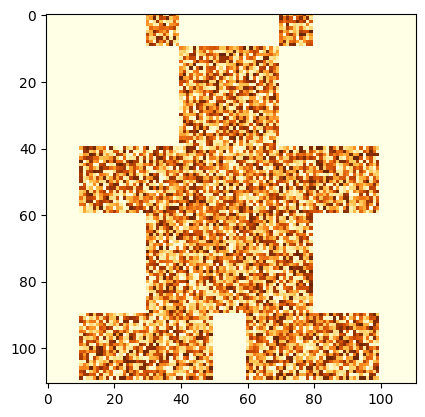

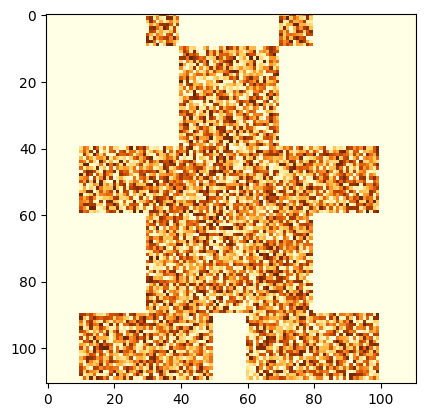

In [2]:
h_t = 0.1
T = np.arange(0, 0 + h_t, h_t)
g = lambda x: 0
Du = 0.4
Dv = 0.6
h_x = 1
C1 = 0.5
C2 = 0.7
C3 = 0.4
C4 = 0.6
C5 = 0.3

coralgol = Bear(params)
coralgol.build_partial_matrices()
coralgol.build_result_matrix()
coralgol.solve_area(Dv, Du, T, h_t, h_x, u_0, v_0, g, C1, C2, C3, C4, C5)
plt.imshow(coralgol.matrix["u"], cmap="YlOrBr")
plt.show()
plt.imshow(coralgol.matrix["v"], cmap="YlOrBr")
plt.show()

# The bear after some time

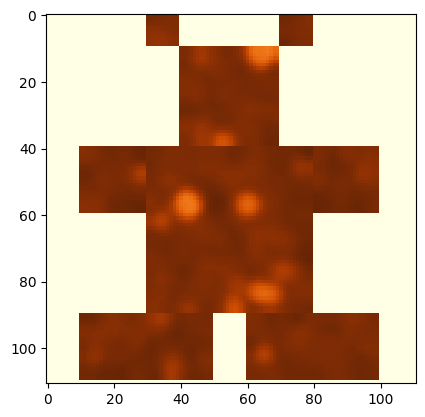

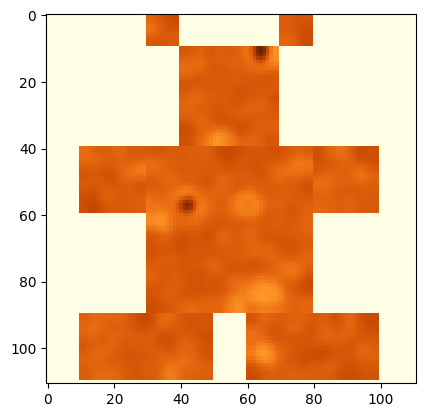

In [22]:
T1 = np.arange(0, 5 + h_t, h_t)

coralgol1 = Bear(params)
coralgol1.build_partial_matrices()
coralgol1.build_result_matrix()
coralgol1.solve_area(Dv, Du, T1, h_t, h_x, u_0, v_0, g, C1, C2, C3, C4, C5)
plt.imshow(coralgol1.matrix["u"], cmap="YlOrBr")
plt.show()
plt.imshow(coralgol1.matrix["v"], cmap="YlOrBr")
plt.show()

# The animation

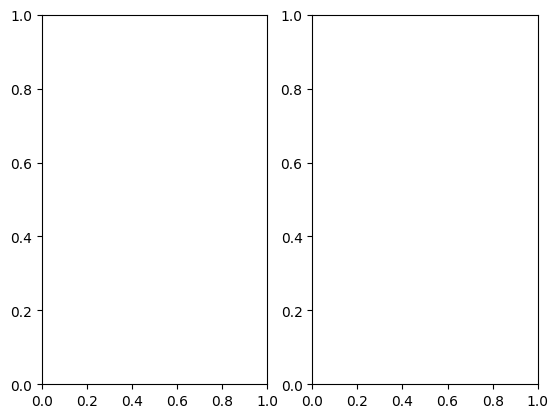

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [15]:
coralgol = Bear(params)
coralgol.build_partial_matrices()
coralgol.build_result_matrix()
coralgol.solve_area(Dv, Du, T, h_t, h_x, u_0, v_0, g, C1, C2, C3, C4, C5)
coralgol.animate()

There is a problem here - the animation doesn't work in the Colab file. I don't understand the reason, because this code works correctly in Pycharm on my personal computer - there is no difference in the code and it generates animations properly (firstly appears the diagram for $u$ solutions, then for $v$).

Nonetheless, the longer is the time span, the more plain and consistent is the pattern on the fur (regardless of the values of parameters). We get a lot of different results - the diagrams have various colors, shades and patterns. Worth mentioning is that in almost every case the solutions of $u$ give darker color (the pigment is stonger). Moreover, sometimes the second diagram is barely visible.